In [2]:
import random
# Install required libraries
# Import required libraries
import gymnasium as gym
from gymnasium import spaces
import matplotlib.pyplot as plt
import numpy as np
import pickle
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from collections import namedtuple, deque
device = torch.device(
    "cuda" if torch.cuda.is_available() else
    "cpu"
)

print(device)
CUDA_LAUNCH_BLOCKING=1

cpu


In [416]:
# Definition of the Grid Environment class.

class GridEnvironment(gym.Env):
    # Attribute of a Gym class that provides info about the render modes
    metadata = { 'render.modes': [] }

    # Initialization function
    def __init__(self):

      self.observation_space = spaces.Discrete(36)
      self.action_space = spaces.Discrete(6)
      self.max_timesteps = 150

      self.timestep = 0
      self.agent_pos = [0, 0]
      self.goal_pos = [5, 5]
      self.package_pos = [3, 1]
      self.state = np.zeros((6,6))
      #Shelves
      self.wall_1 = [3,2]
      self.wall_2 = [4,2]
      self.wall_3 = [5,2]
      self.wall_4 = [1,4]
      self.wall_5 = [1,5]
      self.state[tuple(self.agent_pos)] = 50
      self.state[tuple(self.goal_pos)] = 23
      self.state[tuple(self.package_pos)] = 5
      self.state[tuple(self.wall_1)] = 12
      self.state[tuple(self.wall_2)] = 12
      self.state[tuple(self.wall_3)] = 12
      self.state[tuple(self.wall_4)] = 12
      self.state[tuple(self.wall_5)] = 12

      self.package = 0
      self.pickup = 0

    # Reset function
    def reset(self, **kwargs):

      self.state = np.zeros((6,6))
      self.agent_pos = [0, 0]
      self.state[tuple(self.agent_pos)] = 50
      self.state[tuple(self.goal_pos)] = 23
      self.state[tuple(self.package_pos)] = 5
      self.state[tuple(self.wall_1)] = 12
      self.state[tuple(self.wall_2)] = 12
      self.state[tuple(self.wall_3)] = 12
      self.state[tuple(self.wall_4)] = 12
      self.state[tuple(self.wall_5)] = 12
      self.timestep = 0
      observation = self.state.flatten()
      self.package =0
      info = {}

      return observation, info

    # Step function: Contains the implementation for what happens when an
    # agent takes a step in the environment.
    def step(self, action):
      prev = self.agent_pos.copy()
      if action == 0: #down
        self.agent_pos[0] += 1
      if action == 1: #up
        self.agent_pos[0] -= 1
      if action == 2: #right
        self.agent_pos[1] += 1
      if action == 3: #left
        self.agent_pos[1] -= 1

      reward = -1
      if action == 4: # Pick up
        if np.array_equal(self.agent_pos, self.package_pos) and self.package == 0: #Picked up, in right location
          self.package = 1
          reward = 100
          print("\n----picked up----\n", self.timestep)
          #self.pickup += 1
        elif self.package: #Picked up while holding a package
          reward = -100
        else: # Picked up in wrong location
          reward = -10

      if action == 5:
        #Drop off
        if np.array_equal(self.agent_pos, self.goal_pos) and self.package == 1: #Dropped off in right location
          reward = 100
          print("----dropped off----", self.timestep)
          self.package = 0
          self.timestep = self.max_timesteps
        elif self.package == 0: #Dropped off without holding a package
          reward = -100
        else: #dropped off in wrong location
          reward = -10

      if np.array_equal(self.agent_pos, self.wall_1) or np.array_equal(self.agent_pos, self.wall_2) or np.array_equal(self.agent_pos, self.wall_3) or np.array_equal(self.agent_pos, self.wall_4) or np.array_equal(self.agent_pos, self.wall_5):
        reward = -20
        self.agent_pos = prev
        #print("wall")

      # Comment this to demonstrate the truncation condition.
      if self.agent_pos[0] > 5 or self.agent_pos[0] < 0 or self.agent_pos[1] > 5 or self.agent_pos[1] < 0:
        reward = -25
        #print("bounding: ", self.agent_pos)
      self.agent_pos = np.clip(self.agent_pos, 0, 5)

      self.state = np.zeros((6,6))
      self.state[tuple(self.goal_pos)] = 23
      self.state[tuple(self.package_pos)] = 5
      self.state[tuple(self.wall_1)] = 12
      self.state[tuple(self.wall_2)] = 12
      self.state[tuple(self.wall_3)] = 12
      self.state[tuple(self.wall_4)] = 12
      self.state[tuple(self.wall_5)] = 12
      self.state[tuple(self.agent_pos)] = 50
      observation = self.state.flatten()


      self.timestep += 1

      # Condition to check for termination (episode is over)
      terminated = True if self.timestep >= self.max_timesteps else False

      # Condition to check if agent is traversing to a cell beyond the permitted cells
      # This helps the agent to learn how to behave in a safe and predictable manner
      truncated = True if np.all((np.asarray(self.agent_pos) >=0 ) & (np.asarray(self.agent_pos) <= 6)) else False
      #print(self.agent_pos)

      return observation, reward, terminated, self.package

    # Render function: Visualizes the environment
    def render(self):
      plt.title('Grid Environment')
      plt.imshow(self.state)

In [4]:
class Net(nn.Module):

    def __init__(self, obs, action):
        super(Net, self).__init__()
        self.layer1 = nn.Linear(obs, 144)
        self.layer2 = nn.Linear(144, 144)
        self.layer3 = nn.Linear(144, action)

    def forward(self, x):
        #print(x)
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.layer3(x)

In [432]:
class DQN:
  # initialize values
  def __init__(self, N, C):
    # initialize environment
    self.env = GridEnvironment()
    # initialize replay memory to capacity N
    self.replay = []
    self.capacity = N
    self.pointer = 0
    self.policy_net = Net(2, 6).to(device)
    self.target_net = Net(2, 6).to(device)

    self.optimizer = optim.SGD(self.policy_net.parameters(), lr=0.01)
    self.C = C

  
  # Main training function
  def train(self, episodes, epsilon, discount, action_function, greedy):
    total_reward = [0] * episodes  
    for i in range(episodes):
      # initialize sequence S and preprocessed sequence o
      state = torch.tensor([0, 0],device=device, dtype=torch.float32).unsqueeze(0)
      terminated = False
      pos = package = rewards = steps = 0
      eps = epsilon ** i if not greedy else 0
      self.env.reset()
      while not terminated:
        # Select action
        action_type = action_function(eps, pos, package)

        # Execute action and observe reward
        position, reward, terminated, package = self.env.step(action_type)
        pos = np.where(position == 50)[0][0]

        # Format next state
        next_state = torch.tensor([pos, package], device=device, dtype=torch.float32).unsqueeze(0)

        # # See greedy steps (Might be going back and forth)
        # s = state[0][0].item()
        # if greedy:
        #     print(f"{s} -> {pos}")

        # Add to total rewards for the episode
        rewards += reward
        # Encode action type for ease of use
        action_type = torch.tensor([action_type], device=device, dtype=torch.int64)
        # store transition in replay buffer
        transition = state, action_type,  next_state, reward
        state = next_state

        if self.pointer < self.capacity:
            self.replay.append(transition)
        else:
            self.replay[self.pointer % self.capacity] = transition
        self.pointer += 1

        # When terminated store the last value found
        if terminated:
            transition = state, action_type,  None, reward
            self.replay[self.pointer % self.capacity] = transition

        # Run the replay function
        self.replay_function(discount ** steps)
        # Every C steps update the target function
        if steps % self.C == 0:
            self.target_net.load_state_dict(self.policy_net.state_dict())

        steps += 1
    
      # Decay epsilon after every episode
      print("Episode: ", i)
      total_reward[i] = rewards  
    return total_reward
  # Determine the action for the warehouse environment
  def warehouse_action(self, epsilon, pos, package):
      if np.random.rand() < epsilon:
        action_type = np.random.randint(6)
      else:
        with torch.no_grad():
            state = torch.tensor([pos, package], device=device, dtype=torch.float32).unsqueeze(0)
            action_type = self.policy_net(state).max(1).indices.item()
      return action_type
      
  def replay_function(self, discount):
    BATCH_SIZE = 128
    if len(self.replay) < BATCH_SIZE:
        return
    else:
        sample = random.sample(self.replay, k=BATCH_SIZE)
        Q_list = torch.tensor([] , device=device)
        target_list = torch.tensor([] , device=device)
        action_list = torch.tensor([], dtype=torch.int64, device=device)
        for state, action, next_state, reward in sample:
            if next_state is None:
                Q_list = torch.cat((Q_list, self.policy_net(state)))
                # Make an actions array
                action_list = torch.cat((action_list, action), 0)

                # Calculate updated Q value
                Q_val = torch.tensor([reward], device=device)
                # Add value to expected target list
                target_list = torch.cat((target_list, Q_val))
            else:
                    # Take entire Q row
                    Q_list = torch.cat((Q_list, self.policy_net(state)))
                    # Make an actions array
                    action_list = torch.cat((action_list, action), 0)
                    # Take max expected Q from the target network
                    max_expected = self.target_net(next_state).max(1).values

                    # Calculate updated Q value
                    Q_val = torch.tensor([(max_expected * discount) + reward], device=device)
                    # Add value to expected target list
                    target_list = torch.cat((target_list, Q_val))
                    # t = state[0][0].item()
                    # if t == 19:
                    #     print(self.policy_net(state)[0][4], Q_val)


        # Apply the action list to get real expected Q values
        selected_q_values = Q_list.gather(1, action_list.unsqueeze(1))
        criterion = nn.SmoothL1Loss()

        
        loss = criterion(selected_q_values, target_list.unsqueeze(1))
        #backprop
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

              

  # Save the current weights
  def save(self, filename):
    with open("pickles/" + filename, 'wb') as file:
      pickle.dump(self.policy_net, file)


In [352]:
#Prints the reward per episode graph
def reward_print(reward_per_episode, episodes, info): 
    mins = int(min(reward_per_episode)) - abs(int(min(reward_per_episode)) * (.2))
    maxs = int(max(reward_per_episode)) + abs(int(max(reward_per_episode)) * (.3) )
    plt.figure()
    plt.plot(reward_per_episode)
    plt.xlabel('Episode', fontsize=20)
    plt.ylabel('Cumulative Reward', fontsize=20)
    plt.title(f'Cumulative Reward Per Episode ({info})', fontsize=24)
    plt.xticks([0, episodes * .2, episodes * .4, episodes * .6, episodes * .8, episodes], fontsize=18)
    plt.yticks(fontsize=18)
    plt.ylim(ymin= mins, ymax=maxs)
    plt.xlim(xmin=0, xmax=episodes)
    plt.grid()
    plt.show()

#prints the epsilon decay graph
def ep_decay(eps, episodes):
    epsilon_values = [(eps ** i) * 1 for i in range(episodes)]
    plt.figure()
    plt.plot(epsilon_values, linewidth=4)
    plt.xlabel('Episode', fontsize=20)
    plt.ylabel('Epsilon Value', fontsize=20)
    plt.title(f"Epsilon Decay for {eps}", fontsize=24)
    plt.xticks([0, episodes * .2, episodes * .4, episodes * .6, episodes * .8, episodes], fontsize=18)
    plt.yticks(fontsize=18)
    plt.ylim(ymin=0, ymax=1)
    plt.xlim(xmin=0, xmax=episodes)
    plt.grid()
    plt.show()

def print_Qtable(policy):
    for pos in range(36):
        for package in range(2):
            state = torch.tensor([pos, package],device=device, dtype=torch.float32).unsqueeze(0)
            table = policy(state).squeeze(1)[0]
            ret = f"({pos}, {package}):\n0:{table[0].item()}, 1:{table[1].item()}, 2:{table[2].item()}, 3:{table[3].item()}, 4:{table[4].item()}, 5:{table[5].item()}"
            print(ret)


Episode:  0

----picked up----
 56
Episode:  1
Episode:  2
Episode:  3
Episode:  4
Episode:  5
Episode:  6

----picked up----
 32
Episode:  7
Episode:  8
Episode:  9
Episode:  10
Episode:  11
Episode:  12

----picked up----
 50
Episode:  13
Episode:  14
Episode:  15
Episode:  16
Episode:  17

----picked up----
 10
Episode:  18
Episode:  19
Episode:  20

----picked up----
 32
Episode:  21
Episode:  22
Episode:  23
Episode:  24
Episode:  25
Episode:  26

----picked up----
 70
Episode:  27
Episode:  28
Episode:  29

----picked up----
 128
Episode:  30
Episode:  31
Episode:  32
Episode:  33

----picked up----
 11
Episode:  34
Episode:  35

----picked up----
 11
Episode:  36
Episode:  37

----picked up----
 38
Episode:  38
Episode:  39

----picked up----
 53
Episode:  40

----picked up----
 100
Episode:  41

----picked up----
 41
Episode:  42

----picked up----
 123
Episode:  43
Episode:  44
Episode:  45
Episode:  46
Episode:  47
Episode:  48
Episode:  49
Best reward:  -280


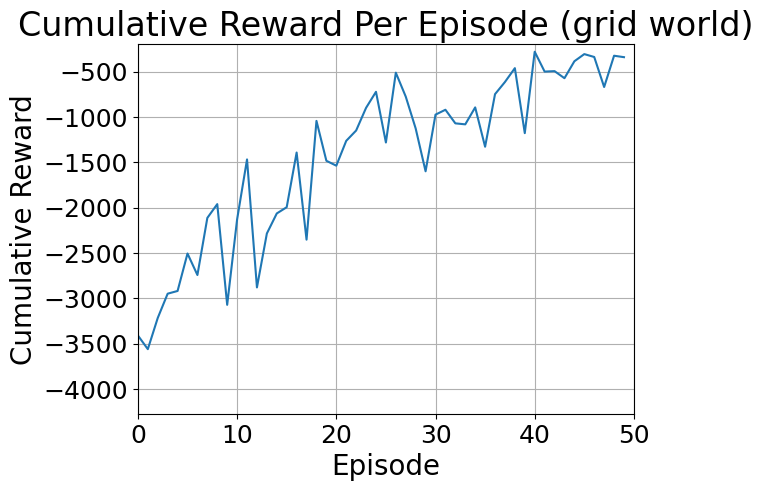

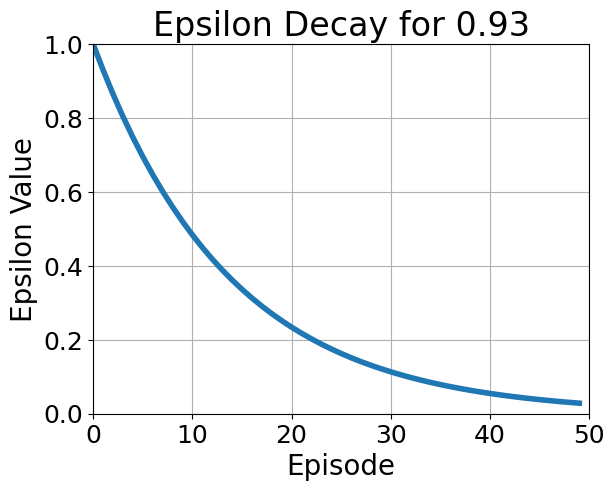

0.0 -> 1
1.0 -> 0
0.0 -> 1
1.0 -> 0
0.0 -> 1
1.0 -> 2
2.0 -> 3
3.0 -> 4
4.0 -> 3
3.0 -> 2
2.0 -> 1
1.0 -> 7
7.0 -> 8
8.0 -> 14
14.0 -> 13
13.0 -> 7
7.0 -> 8
8.0 -> 2
2.0 -> 1
1.0 -> 7
7.0 -> 8
8.0 -> 14
14.0 -> 13
13.0 -> 19
19.0 -> 18
18.0 -> 24
24.0 -> 18
18.0 -> 12
12.0 -> 6
6.0 -> 12
12.0 -> 6
6.0 -> 7
7.0 -> 13
13.0 -> 7
7.0 -> 13
13.0 -> 7
7.0 -> 13
13.0 -> 7
7.0 -> 13
13.0 -> 7
7.0 -> 8
8.0 -> 14
14.0 -> 14
14.0 -> 14
14.0 -> 14
14.0 -> 14
14.0 -> 14
14.0 -> 8
8.0 -> 14
14.0 -> 14
14.0 -> 14
14.0 -> 8
8.0 -> 14
14.0 -> 8
8.0 -> 14
14.0 -> 14
14.0 -> 14
14.0 -> 14
14.0 -> 14
14.0 -> 15
15.0 -> 21
21.0 -> 27
27.0 -> 21
21.0 -> 21
21.0 -> 15
15.0 -> 16
16.0 -> 16
16.0 -> 15
15.0 -> 21
21.0 -> 27
27.0 -> 21
21.0 -> 27
27.0 -> 21
21.0 -> 27
27.0 -> 21
21.0 -> 15
15.0 -> 21
21.0 -> 27
27.0 -> 21
21.0 -> 27
27.0 -> 21
21.0 -> 27
27.0 -> 21
21.0 -> 27
27.0 -> 21
21.0 -> 27
27.0 -> 21
21.0 -> 27
27.0 -> 21
21.0 -> 27
27.0 -> 21
21.0 -> 27
27.0 -> 21
21.0 -> 15
15.0 -> 21
21.0 -> 15
15.0 

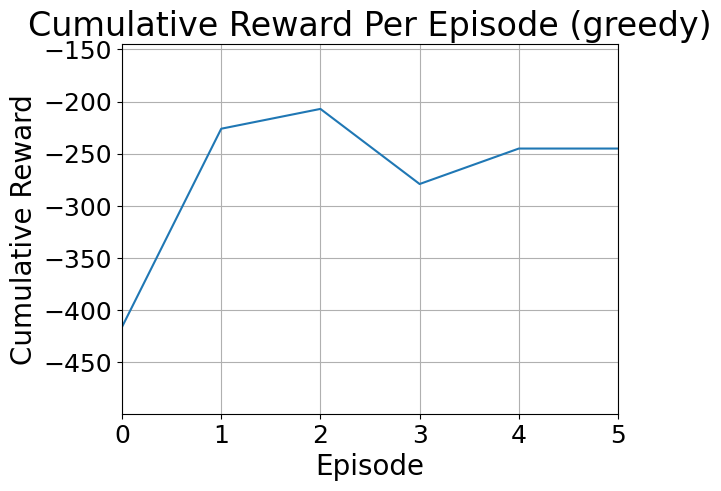

In [430]:
N = 5000
C = 10
env = GridEnvironment()
agent = DQN(N, C)

episodes = 50
epsilon = .93
discount = .99
action = agent.warehouse_action
total_rewards = agent.train(episodes, epsilon, discount, action, False)
print("Best reward: ", max(total_rewards))
agent.save("drpreisl_angustsa_assignment2_part2_dqn_gridworld.pickle")
reward_print(total_rewards, episodes, "grid world")
ep_decay(epsilon, episodes)
total_rewards = agent.train(6, epsilon, discount, action, True)
reward_print(total_rewards, 5, "greedy")

In [418]:
print_Qtable(agent.policy_net)


(0, 0):
0:-4.256524085998535, 1:-23.100841522216797, 2:-1.3640106916427612, 3:-1.8137857913970947, 4:-11.875450134277344, 5:-74.26509094238281
(0, 1):
0:-3.508329391479492, 1:-19.756092071533203, 2:-1.2066541910171509, 3:-1.630937933921814, 4:-10.416214942932129, 5:-63.05467224121094
(1, 0):
0:-4.699248790740967, 1:-23.54338264465332, 2:-1.5114866495132446, 3:-1.456565022468567, 4:-12.545512199401855, 5:-81.1836166381836
(1, 1):
0:-3.783578872680664, 1:-19.8686580657959, 2:-1.3318525552749634, 3:-1.4889720678329468, 4:-10.946609497070312, 5:-68.13060760498047
(2, 0):
0:-4.6530327796936035, 1:-21.555984497070312, 2:-1.647426962852478, 3:-1.4204210042953491, 4:-12.260791778564453, 5:-82.24165344238281
(2, 1):
0:-3.7226483821868896, 1:-17.985553741455078, 2:-1.4357489347457886, 3:-1.4665213823318481, 4:-10.66545581817627, 5:-69.0163345336914
(3, 0):
0:-4.4883599281311035, 1:-19.19803810119629, 2:-1.7354801893234253, 3:-1.5489133596420288, 4:-11.802240371704102, 5:-82.0605697631836
(3, 1):

In [428]:
total_rewards = agent.train(6, epsilon, discount, action, True)
reward_print(total_rewards, 5, "grid world")

0.0 -> 6
6.0 -> 7
7.0 -> 8
8.0 -> 2
2.0 -> 1
1.0 -> 7
7.0 -> 8
8.0 -> 14
14.0 -> 13
13.0 -> 19
19.0 -> 18
18.0 -> 24
24.0 -> 24
24.0 -> 18
18.0 -> 18
18.0 -> 24
24.0 -> 18
18.0 -> 12
12.0 -> 18
18.0 -> 12
12.0 -> 13
13.0 -> 7
7.0 -> 13
13.0 -> 7
7.0 -> 13
13.0 -> 7
7.0 -> 13
13.0 -> 7
7.0 -> 8
8.0 -> 14
14.0 -> 14
14.0 -> 14
14.0 -> 8
8.0 -> 14
14.0 -> 15
15.0 -> 21
21.0 -> 15
15.0 -> 21
21.0 -> 15
15.0 -> 21
21.0 -> 15
15.0 -> 9
9.0 -> 15
15.0 -> 9
9.0 -> 15
15.0 -> 21
21.0 -> 15
15.0 -> 21
21.0 -> 15
15.0 -> 21
21.0 -> 15
15.0 -> 21
21.0 -> 15
15.0 -> 21
21.0 -> 15
15.0 -> 21
21.0 -> 15
15.0 -> 21
21.0 -> 15
15.0 -> 9
9.0 -> 9
9.0 -> 9
9.0 -> 15
15.0 -> 9
9.0 -> 15
15.0 -> 16
16.0 -> 22
22.0 -> 16
16.0 -> 22
22.0 -> 16
16.0 -> 22
22.0 -> 16
16.0 -> 22
22.0 -> 28
28.0 -> 22
22.0 -> 16
16.0 -> 22
22.0 -> 16
16.0 -> 16
16.0 -> 17
17.0 -> 23
23.0 -> 17
17.0 -> 17
17.0 -> 16
16.0 -> 22
22.0 -> 16
16.0 -> 22
22.0 -> 16
16.0 -> 22
22.0 -> 16
16.0 -> 22
22.0 -> 16
16.0 -> 22
22.0 -> 16
16.0 

KeyboardInterrupt: 